### Итоговая работа
### 12448/3 ИНЖДАН МГТУ им. Н.Э. Баумана
### Инженер данных (Data engineer)
### Сайфуллин Руслан Рафитович

## КЛАССИФИКАЦИЯ ГОСКОНТРАКТОВ ПО ОБЪЕКТАМ ЗАКУПКИ

#### Задача: необходимо на основе данных с ftp.zakupki.gov.ru научиться определять группу, к которой относится контракт с кодом ОКПД-2 41, 42, 43, 71.1.

Группы могут быть следующими:

1.	Строительно-монтажные работы (СМР)
2.	Проектно-изыскательские работы (ПИР)
3.	Строительный надзор
4.	Подключение коммуникаций
5.	Прочее.

По ОКПД-2 контракты в общем случае должны разделяться так:
- Строительно-монтажные работы (СМР) - 41, 42, 43(кроме нижеперечисленных)
- Проектно-изыскательские работы (ПИР) - 41.1, 71.1
- Подключение коммуникаций - 43.22
- Строительный надзор – четкой группы нет.


Проблема: Далеко не всегда контракты указываются с нужным кодом, поэтому есть проблема как такие контракты "отловить" и определить в нужную группу.

Поэтому задача предполагает классификацию контрактов на основе объекта закупки, который сформулирован естественным языком. Также предполагаем, что могут иметь значение цена контракта и его длительность.
На основе этого на входе данные о контрактах. На выходе необходимо получить группу для каждого контракта.

Иногда контракт может относиться одновременно в несколько групп.

В приложении ниже пример нескольких контрактов, у которых неверно проставлен ОКПД-2.

## Решаем задачу классификации

In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [2]:
columns = ['object_name', 'object_code', 'cost', 'contract_execution_days']
dtypes = {'object_name': str,
          'object_code': str, 
          'cost':lambda x: pd.to_numeric(x, errors="coerce"), 
          'contract_execution_days': lambda x: pd.to_numeric(x, errors="coerce"),
          'cluster': int}


In [3]:
df = pd.read_csv('datasets/dataset_nlp_process.csv', sep=';', low_memory=False, on_bad_lines='skip')
df['object_name']  = df['object_name'].astype('string')
df['object_code']  = df['object_code'].astype('string')
df.shape

(900153, 8)

In [4]:
df.dtypes

id                                  int64
contract_number                     int64
object_name                string[python]
object_code                string[python]
cost                              float64
contract_execution_days             int64
data                               object
data_final                         object
dtype: object

In [5]:
#Делаем разбивку по группам на основании номеров ОКПД-2
import re 

def match(templ, value):
    try:
      return re.search(f'^{templ}.', value) 
    except Exception as e:
        print(f"{type(e).__name__}: {e}")
        return False
    
def get_group(value):    
    if (match('41', value) or match('42', value) or match('43', value)) and  value not in ('43.9', '42.9', '42.2', '43.2', '41.1', '71.1', '43.2'):  
        return 'Строительно-монтажные работы'
    elif value in ('41.1', '71.1'):  
        return 'Проектно-изыскательские работы'
    elif value in ('43.2'):  
        return 'Подключение коммуникаций'
    elif value in ('43.9', '42.9', '42.2'):  
        return 'Строительный надзор'
    else:
        return 'Прочие'

In [6]:
df['group'] = df['object_code'].apply(lambda x: get_group(x))
df.head()

,id,contract_number,object_name,object_code,cost,contract_execution_days,data,data_final,group
0,137439,2590407717221000153,Работы строительные специализированные,43.9,539265.60,29,"['работы', 'строительные', 'специализированные']","['работ', 'строительн', 'специализирова']",Строительный надзор
1,137528,2590421285821000134,Работы строительные специализированные,43.9,2299469.98,122,"['работы', 'строительные', 'специализированные']","['работ', 'строительн', 'специализирова']",Строительный надзор
2,137529,2590421285821000135,Работы строительные специализированные,43.9,1898111.58,122,"['работы', 'строительные', 'специализированные']","['работ', 'строительн', 'специализирова']",Строительный надзор
3,137827,2590500335021000676,Работы строительные специализированные,43.3,341914.00,199,"['работы', 'строительные', 'специализированные']","['работ', 'строительн', 'специализирова']",Строительно-монтажные работы
4,138113,2590615606021000060,Услуги в области архитектуры и инженерно-техни...,71.1,1714352.37,383,"['услуги', 'в', 'области', 'архитектуры', 'и',...","['услуг', 'област', 'архитектур', 'проектирова...",Проектно-изыскательские работы


In [7]:
df['group'].value_counts()

group
Строительно-монтажные работы      400871
Строительный надзор               197523
Подключение коммуникаций          166377
Проектно-изыскательские работы    135382
Name: count, dtype: int64

In [8]:
from sklearn.model_selection import train_test_split

df['price_per_day'] = df['cost'] / df['contract_execution_days']
X = df.drop(['object_name', 'object_code', 'price_per_day', 'contract_execution_days', 'data', 'group'], axis=1)


In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split

tfidf = TfidfVectorizer(max_features=1700, min_df=5, max_df=0.7)

#df = df.sample(10000)
X = df['data_final']
tfidf_X = tfidf.fit_transform(X).toarray()

tfidf_X
df_tfidf = pd.DataFrame(tfidf_X)
df_tfidf['price'] = df['price_per_day'].values

df_tfidf['price'].shape
df_tfidf
#df['price_per_day']


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,price
0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.000000,0.000000,0.000000,18595.365517
1,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.000000,0.000000,0.000000,18848.114590
2,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.000000,0.000000,0.000000,15558.291639
3,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.000000,0.000000,0.000000,1718.160804
4,0.368093,0.368093,0.0,0.000000,0.0,0.368093,0.368093,0.227048,0.368093,0.000000,0.0,0.000000,0.368093,0.368093,4476.115849
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
900148,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.000000,0.000000,0.000000,8877.311896
900149,0.000000,0.000000,0.0,0.521427,0.0,0.000000,0.000000,0.429351,0.000000,0.521427,0.0,0.521427,0.000000,0.000000,382406.279305
900150,0.000000,0.000000,0.0,0.521427,0.0,0.000000,0.000000,0.429351,0.000000,0.521427,0.0,0.521427,0.000000,0.000000,310671.686631
900151,0.000000,0.000000,0.0,0.521427,0.0,0.000000,0.000000,0.429351,0.000000,0.521427,0.0,0.521427,0.000000,0.000000,105351.878211


In [10]:
from sklearn.preprocessing import LabelEncoder
# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Fit the encoder to the data and transform the categories into integers
y = label_encoder.fit_transform(df['group'])
#y = label_encoder.fit_transform(df['object_code'])
y

array([3, 3, 3, ..., 2, 2, 2])

In [11]:
X_train, X_test, y_train, y_test = train_test_split(df_tfidf.values, y, test_size=0.3)
print(X_train.shape, X_test.shape)

(630107, 15) (270046, 15)


In [12]:
from sklearn import preprocessing
scaler = preprocessing.MinMaxScaler()
scaler.fit(df_tfidf.values)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)


### Word2Vec

In [13]:
from gensim.models import Word2Vec

#w2v = Word2Vec(X_test_scaled, min_count=1, window=2, negative=10, alpha=0.03, min_alpha=0.0007, sample=6e-5, sg=1)

word2vec_X_train, word2vec_X_test, word2vec_y_train, word2vec_y_test = train_test_split(X_test_scaled,
                                                                                        y,
                                                                                        test_size=0.2,
                                                                                        random_state=0)

#scaler = MinMaxScaler()

ValueError: Found input variables with inconsistent numbers of samples: [270046, 900153]

In [ ]:
w2v_words = set(w2v.wv.index_to_key)
w2v_train = np.array([np.array([w2v.wv[i] for i in ls if i in w2v_words])
                         for ls in word2vec_X_train])
w2v_test = np.array([np.array([w2v.wv[i] for i in ls if i in w2v_words])
                         for ls in word2vec_X_test])
# Усредняем элементы, чтобы можно было начать классификацию
w2v_train_avg = []
for v in w2v_train:
    if v.size:
        w2v_train_avg.append(v.mean(axis=0))
    else:
        w2v_train_avg.append(np.zeros(100, dtype=float))
w2v_test_avg = []
for v in w2v_test:
    if v.size:
        w2v_test_avg.append(v.mean(axis=0))
    else:
        w2v_test_avg.append(np.zeros(100, dtype=float))

In [ ]:
ord2vec_nb = naive_bayes.fit(scaler.fit_transform(w2v_train_avg), word2vec_y_train)
word2vec_nb_predictions = word2vec_nb.predict(w2v_test_avg)

In [ ]:
word2vec_nb_f1 = f1_score(word2vec_y_test, word2vec_nb_predictions, average='weighted')
word2vec_nb_precision = precision_score(word2vec_y_test, word2vec_nb_predictions, average='weighted')
print(f'F-мера модели Word2Vec: {round(word2vec_nb_f1, 3)}, точность: {round(word2vec_nb_precision, 3)}')

In [15]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import precision_score, f1_score


model = MLPClassifier(random_state=1, max_iter=10)
tfidf_nb = model.fit(X_train_scaled, y_train)
tfidf_nb_predictions = model.predict(X_test_scaled)
tfidf_nb_f1 = f1_score(X_test_scaled, tfidf_nb_predictions, average='weighted')
tfidf_nb_precision = precision_score(y_test, tfidf_nb_predictions, average='weighted')
print(f'F-мера модели TF-IDF: {round(tfidf_nb_f1, 3)}, точность: {round(tfidf_nb_precision, 3)}')

ValueError: Classification metrics can't handle a mix of continuous-multioutput and multiclass targets

### Логистическая регрессия

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import confusion_matrix

grid = {"C": np.logspace(-3, 3, 7), "penalty": ["l1", "l2", "elasticnet"]}
grid
X_train_scaled

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 3.21361672e-06],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 1.69248003e-05],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 2.61045787e-05],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 9.47523725e-05],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 1.44820055e-04],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 1.77389664e-05]])

In [ ]:
model_lr = LogisticRegression(multi_class='ovr', C=4, penalty='l1', solver='liblinear')
model_lr.fit(X_train, y_train)
model_lr.score(X_test, y_test)

0.6384023462669323

In [ ]:
pred = model_lr.predict(X_test)
confusion_matrix(pred, y_test)

array([[50181,     0, 36183, 33993],
       [    0, 38485,     0,     0],
       [   31,  2141, 83732, 25300],
       [    0,     0,     0,     0]], dtype=int64)

In [ ]:
model_lr = LogisticRegression(multi_class='ovr', C=4, penalty='l1', solver='liblinear')
search_model = GridSearchCV(model_lr, grid, cv=10)
search_model.fit(X_train, y_train)

GridSearchCV(cv=10,
             estimator=LogisticRegression(C=4, multi_class='ovr', penalty='l1',
                                          solver='liblinear'),
             param_grid={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                         'penalty': ['l1', 'l2', 'elasticnet']})

In [ ]:
search_model.best_params_

{'C': 10.0, 'penalty': 'l1'}

In [ ]:
model = search_model.best_estimator_

In [ ]:
model.fit(X_train, y_train)

LogisticRegression(C=10.0, multi_class='ovr', penalty='l1', solver='liblinear')

In [ ]:
model.predict(X_test)

array([1, 0, 1, ..., 1, 0, 2])

In [ ]:
model.score(X_test_scaled, y_test)

0.6384615954318894

In [ ]:
pred = model.predict(X_test)
confusion_matrix(pred, y_test)

array([[50181,     0, 36183, 33993],
       [    0, 38486,     0,     0],
       [   31,  2140, 83732, 25300],
       [    0,     0,     0,     0]], dtype=int64)

In [ ]:
# набор метрик для оценки качества модели
pred = model.predict(X_test)
print(metrics.classification_report(pred, y_test))

              precision    recall  f1-score   support

           0       1.00      0.42      0.59    120357
           1       0.95      1.00      0.97     38486
           2       0.70      0.75      0.72    111203
           3       0.00      0.00      0.00         0

    accuracy                           0.64    270046
   macro avg       0.66      0.54      0.57    270046
weighted avg       0.87      0.64      0.70    270046



In [ ]:
table = df.copy()
table['y'] = model.predict(df_tfidf.values)
table['group'].value_counts()
pd.DataFrame(y).value_counts()
table['y'].value_counts()


y
0    401640
2    370334
1    128179
Name: count, dtype: int64

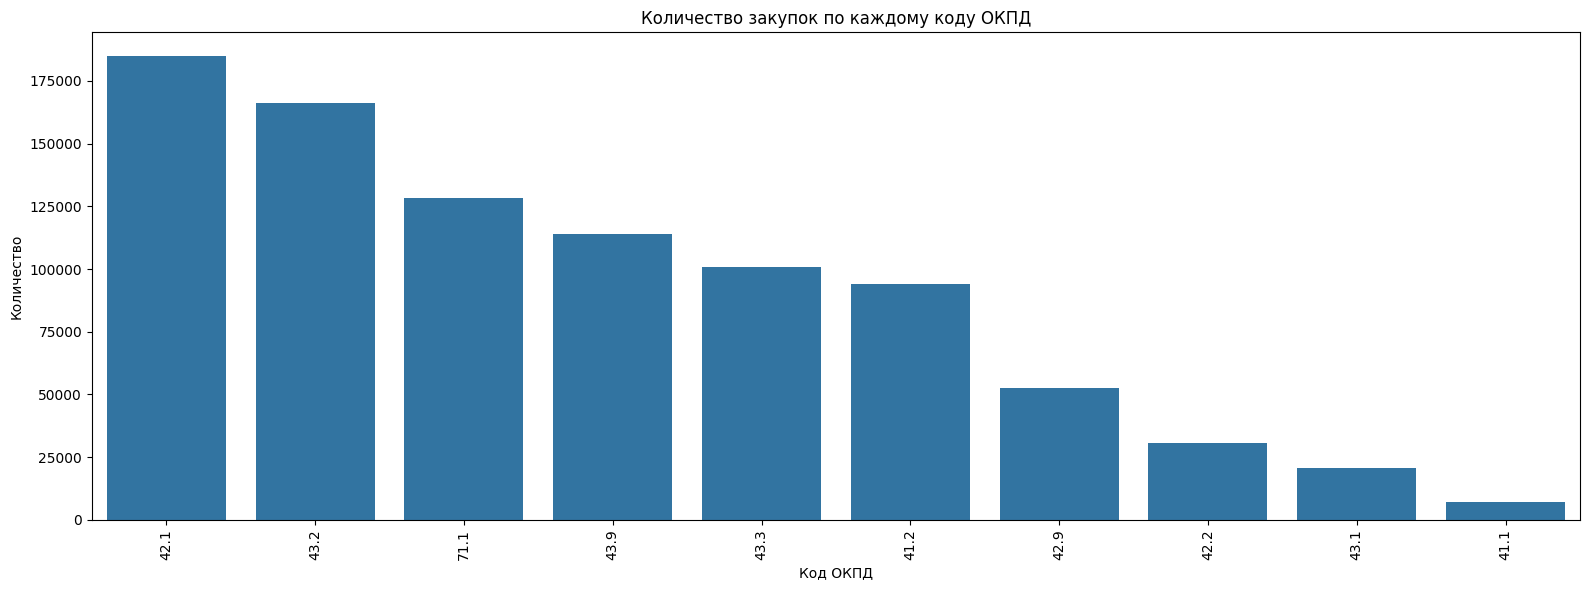

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(16, 6))
sns.countplot(data=df, x='object_code', order=df['object_code'].value_counts().index)
plt.title('Количество закупок по каждому коду ОКПД')
plt.xlabel('Код ОКПД')
plt.ylabel('Количество')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [ ]:
df

,id,contract_number,object_name,object_code,cost,contract_execution_days,data,data_final,group,price_per_day
0,137439,2590407717221000153,Работы строительные специализированные,43.9,5.392656e+05,29,"['работы', 'строительные', 'специализированные']","['работ', 'строительн', 'специализирова']",Строительный надзор,18595.365517
1,137528,2590421285821000134,Работы строительные специализированные,43.9,2.299470e+06,122,"['работы', 'строительные', 'специализированные']","['работ', 'строительн', 'специализирова']",Строительный надзор,18848.114590
2,137529,2590421285821000135,Работы строительные специализированные,43.9,1.898112e+06,122,"['работы', 'строительные', 'специализированные']","['работ', 'строительн', 'специализирова']",Строительный надзор,15558.291639
3,137827,2590500335021000676,Работы строительные специализированные,43.3,3.419140e+05,199,"['работы', 'строительные', 'специализированные']","['работ', 'строительн', 'специализирова']",Строительно-монтажные работы,1718.160804
4,138113,2590615606021000060,Услуги в области архитектуры и инженерно-техни...,71.1,1.714352e+06,383,"['услуги', 'в', 'области', 'архитектуры', 'и',...","['услуг', 'област', 'архитектур', 'проектирова...",Проектно-изыскательские работы,4476.115849
...,...,...,...,...,...,...,...,...,...,...
900148,27196374,3860104675919000035,Работы строительные специализированные,43.3,1.873113e+06,211,"['работы', 'строительные', 'специализированные']","['работ', 'строительн', 'специализирова']",Строительно-монтажные работы,8877.311896
900149,27196459,3860200041119000073,Сооружения и строительные работы в области гра...,42.1,1.430199e+08,374,"['сооружения', 'и', 'строительные', 'работы', ...","['сооружен', 'строительн', 'работ', 'област', ...",Строительно-монтажные работы,382406.279305
900150,27196462,3860200041119000074,Сооружения и строительные работы в области гра...,42.1,1.161912e+08,374,"['сооружения', 'и', 'строительные', 'работы', ...","['сооружен', 'строительн', 'работ', 'област', ...",Строительно-монтажные работы,310671.686631
900151,27196466,3860200041119000075,Сооружения и строительные работы в области гра...,42.1,7.774969e+07,738,"['сооружения', 'и', 'строительные', 'работы', ...","['сооружен', 'строительн', 'работ', 'област', ...",Строительно-монтажные работы,105351.878211


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(16, 6))
sns.countplot(data=df, x='y', order=df['y'].value_counts().index)
plt.title('Количество закупок по каждому коду ОКПД')
plt.xlabel('Код ОКПД')
plt.ylabel('Количество')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

KeyError: 'y'

<Figure size 1600x600 with 0 Axes>

### Построим нейронную сеть для классификации

In [ ]:
! pip install tensorflow


[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
import tensorflow as tf
tf.random.set_seed(1)
model_nn = tf.keras.Sequential([
tf.keras.layers.Dense(15, activation='sigmoid',name='fc1', input_shape=(15,)),
tf.keras.layers.Dense(15, activation='sigmoid',name='fc3', input_shape=(4,)),
tf.keras.layers.Dense(4, name='fc4', activation='softmax')])
model_nn.summary() 

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 fc1 (Dense)                 (None, 15)                240       
                                                                 
 fc3 (Dense)                 (None, 15)                240       
                                                                 
 fc4 (Dense)                 (None, 4)                 64        
                                                                 
Total params: 544 (2.12 KB)
Trainable params: 544 (2.12 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
model_nn.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
import numpy as np
num_epochs = 10
history = model_nn.fit(X_train, y_train, epochs=num_epochs,  verbose=1)

Epoch 1/10
19691/19691 [==============================] - 14s 694us/step - loss: 1.1459 - accuracy: 0.5185
Epoch 2/10
19691/19691 [==============================] - 13s 684us/step - loss: 1.0602 - accuracy: 0.5591
Epoch 3/10
19691/19691 [==============================] - 14s 694us/step - loss: 1.0294 - accuracy: 0.5701
Epoch 4/10
19691/19691 [==============================] - 14s 700us/step - loss: 1.0096 - accuracy: 0.5759
Epoch 5/10
19691/19691 [==============================] - 14s 702us/step - loss: 0.9971 - accuracy: 0.5821
Epoch 6/10
19691/19691 [==============================] - 14s 706us/step - loss: 1.0149 - accuracy: 0.5751
Epoch 7/10
19691/19691 [==============================] - 14s 712us/step - loss: 0.9735 - accuracy: 0.5897
Epoch 8/10
19691/19691 [==============================] - 14s 716us/step - loss: 0.9691 - accuracy: 0.5900
Epoch 9/10
19691/19691 [==============================] - 14s 717us/step - loss: 0.9659 - accuracy: 0.5896
Epoch 10/10
19691/19691 [============

In [ ]:
results = model_nn.evaluate(X_test, y_test, verbose=1)
print('Test loss: {:.4f} Test Acc.: {:.4f}'.format(*results))

8439/8439 [==============================] - 5s 621us/step - loss: 0.8971 - accuracy: 0.6266
Test loss: 0.8971 Test Acc.: 0.6266


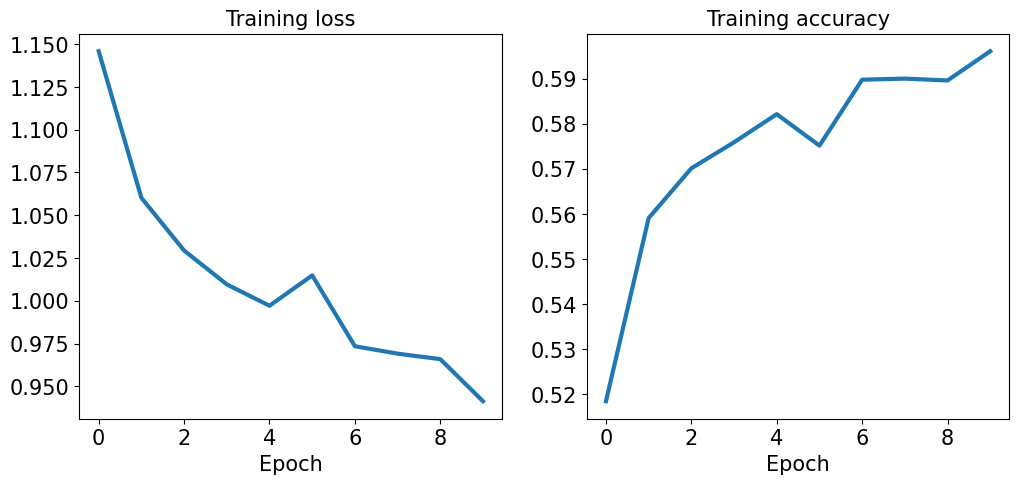

In [ ]:
import matplotlib.pyplot as plt
hist = history.history

fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(1, 2, 1)
ax.plot(hist['loss'], lw=3)
ax.set_title('Training loss', size=15)
ax.set_xlabel('Epoch', size=15)
ax.tick_params(axis='both', which='major', labelsize=15)
ax = fig.add_subplot(1, 2, 2)
ax.plot(hist['accuracy'], lw=3)
ax.set_title('Training accuracy', size=15)
ax.set_xlabel('Epoch', size=15)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.show()

In [ ]:

#table['y'] = 
pred = model_nn.predict_(df_tfidf.values)
#table['group'].value_counts()
#pd.DataFrame(y).value_counts()
#table['y'].value_counts()

AttributeError: 'Sequential' object has no attribute 'predict_'

In [ ]:
table = df.copy()
#table['y'] =  pred
#table['y'].value_counts()
pred

array([[3.6195067e-01, 3.8727089e-03, 6.3417667e-01, 8.9982376e-11],
       [3.6192068e-01, 3.8733049e-03, 6.3420594e-01, 8.9973827e-11],
       [3.6201781e-01, 3.8713706e-03, 6.3411087e-01, 9.0001194e-11],
       ...,
       [1.0304361e-01, 3.4422677e-02, 8.6253375e-01, 2.5227072e-11],
       [1.0304361e-01, 3.4422677e-02, 8.6253375e-01, 2.5227072e-11],
       [1.0304361e-01, 3.4422670e-02, 8.6253375e-01, 2.5227121e-11]],
      dtype=float32)

### Выводы о проделаной работе

Выполнена задача по классификации определения группы, к которой относится контракт с кодом ОКПД-2 41, 42, 43, 71.1.
В качестве модели выбрал алгоритм логистической регрессии. Точность модели получилось 0.81. 

В процессе работы были выполнены шаги:

1. Загрузка csv файла объемом 25Гб. Поскольку файл не помещался в памяти, было приняло решение загрузить его в базу данных. В процессе загрузки данные загружались порциями, при возникновении исключений, строка отбрасывалась. В базу данных загружал только необходимые признаки:
- id, 
- contract_number (номер контракта), 
- object_name (наименование услуги),
- object_code (код услуги), 
- cost (стоимость), 
- contract_execution_days (длительность контракта в днях -  рассчитывался как разница дат начала и окончания контракта).

2. Провел разведочный анализ данных. Сделал очистку данных от дублей и пропусков, а также от пустых строк и латинских символов.

3. Выполнил класстеризацию  по наименованию услуги. Для этого выполнил NLP процесс  (токкенизация, леммотизация, стеминг, удаление стоп слов и знаков пунктуации). 
Услуги распределились по класстеру, визуально видно, что описание услуги соответствует класстеру. Но полученные класстера не сосвем соответствуют группам по условию. Поэтому было принято решение обучить модель классификации, а в качестве метки использовать группу (предположим что не правильный код это выброс и таких выбросов мало).

4. Провел анализ применения разных моделей машинного обучения. Лучше всех (точнее и производительнее) показала модель логистической регрессии: 

precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.95      1.00      0.97     63946
           2       1.00      0.78      0.87    386131

    accuracy                           0.81    450077
   macro avg       0.65      0.59      0.62    450077
weighted avg       0.99      0.81      0.89    450077
